In [1]:
import pymaster as nmt
import numpy as np
import healpy as hp
import wget
import os
import matplotlib.pyplot as plt
from astropy.io import fits

These notebooks aim to provide a comprehensive review of the functionality implemented in NaMaster. No rigorous mathematical derivations of any statements made will be provided, and users are referred to the references below for further details:
- **A19**. The original NaMaster paper (Alonso et al. 2019 https://arxiv.org/abs/1809.09603).
- **G19**. Garcia-Garcia et al. 2019 (https://arxiv.org/abs/1906.11765), which introduces the basic approximation used by NaMaster to estimate covariance matrix.
- **N20**. Nicola et al. 2020 (https://arxiv.org/abs/2010.09717), which refined these approximations and described in detail the procedure to estimate cosmic shear power spectra.
- **W24**. Wolz et al. 2024 (TBD), which introduced the formalism for catalog-based $C_\ell$s.

# 4 Catalog-based power spectra <a class="anchor" id="S4"></a>
This tutorial presents the infrastructure built in NaMaster for the calculation of power spectra of fields defined at (or from) the positions of a discrete set of sources. The methodology is described in detail in W24.

The code below demonstrates the use of this methodology for a realistic galaxy catalog, in the context of a spin-2 field (similar to the case of cosmic shear catalogs), and in the context of galaxy clustering, where the overdensity of sources themselves is the field of interest.

# Table of contents

* [4.1 Catalog-based fields](#Ss4.1)
* [4.2 Example 1: spin-0 field](#Ss4.2)
* [4.3 Example 2: spin-2 field](#Ss4.3)
* [4.4 Example 3: clustering](#Ss4.4)
* [4.5 Combining catalog-based and normal fields](#Ss4.5)

## 4.1 Catalog-based fields <a class="anchor" id="Ss4.1"></a>
In their most general form, catalog-based fields are fields with values only defined at the angular positions of a discrete set of sources. These fields are then defined by the angular coordinates of the sources, the corresponding measured field values and, additionally, the source weights, which may be used, for instance, to optimally combine measurements from sources with varying signal-to-noise ratios.

Below we show how to construct a standard catalog-based field. We will use the positions of sources in a real catalog: the Quaia quasar sample of [Storey-Fisher et al. 2023](https://arxiv.org/abs/2306.17749), [Alonso et al. 2023](https://arxiv.org/abs/2306.17748). We first start by downloading the catalog and its angular selection function. For our discussion of clustering, in [Section 4.4](#Ss4.4), we will need a random catalog for this sample, so we will construct it here too from the selection function.

In [2]:
# Download and read selection function
fname_sel = 'selection_function_NSIDE64_G20.5_zsplit2bin0.fits'
if not os.path.isfile(fname_sel):
    wget.download("https://zenodo.org/records/8098636/files/selection_function_NSIDE64_G20.5_zsplit2bin0.fits?download=1")
sel = hp.read_map(fname_sel)

# Download and read catalog
fname_cat = 'quaia_G20.5.fits'
if not os.path.isfile(fname_cat):
    wget.download("https://zenodo.org/records/10403370/files/quaia_G20.5.fits?download=1")
cat = fits.open(fname_cat)[1].data
# Select only sources with redshifts z < 1.47 (first bin of Alonso et al. 2023)
cat = cat[cat['redshift_quaia'] < 1.47]
nsrc = len(cat)
print(f"The catalog has {nsrc} sources.")

# Since we will need them for clustering, let us also generate a random catalog
nran = 50*nsrc
nside_sel = hp.npix2nside(len(sel))
th_ran = np.arccos(-1+2*np.random.rand(nran))
phi_ran = 2*np.pi*np.random.rand(nran)
u_ran = np.random.rand(nran)
ipix_ran = hp.ang2pix(nside_sel, th_ran, phi_ran)
keep = u_ran <= sel[ipix_ran]
nran = np.sum(keep)
print(f"Random catalog has {nran} sources")
# Assign RA, Dec, and weights
pos_ran = np.array([np.degrees(phi_ran[keep]), 90-np.degrees(th_ran[keep])])
w_ran = np.ones(nran)
ipix_ran = ipix_ran[keep]

The catalog has 644786 sources.
Random catalog has 22392293 sources


Having read the catalog, let's assign each source a weight (we will use equal unit weights for simplicity) and field values. For the latter, we will generate a Gaussian realisation of a continuous field from a known power spectrum at a high resolution, and simply assign the value of that field at the pixel occupied by each source. We use a simple power spectrum of the form $C_\ell=1/(\ell+10)$. The corresponding field is arbitrary. Use your imagination and pretend it's the value of e.g. the lensing convergence at the source's position (perhaps estimated from the source's size), or the value of the integrated electron density, if these sources were FRBs.

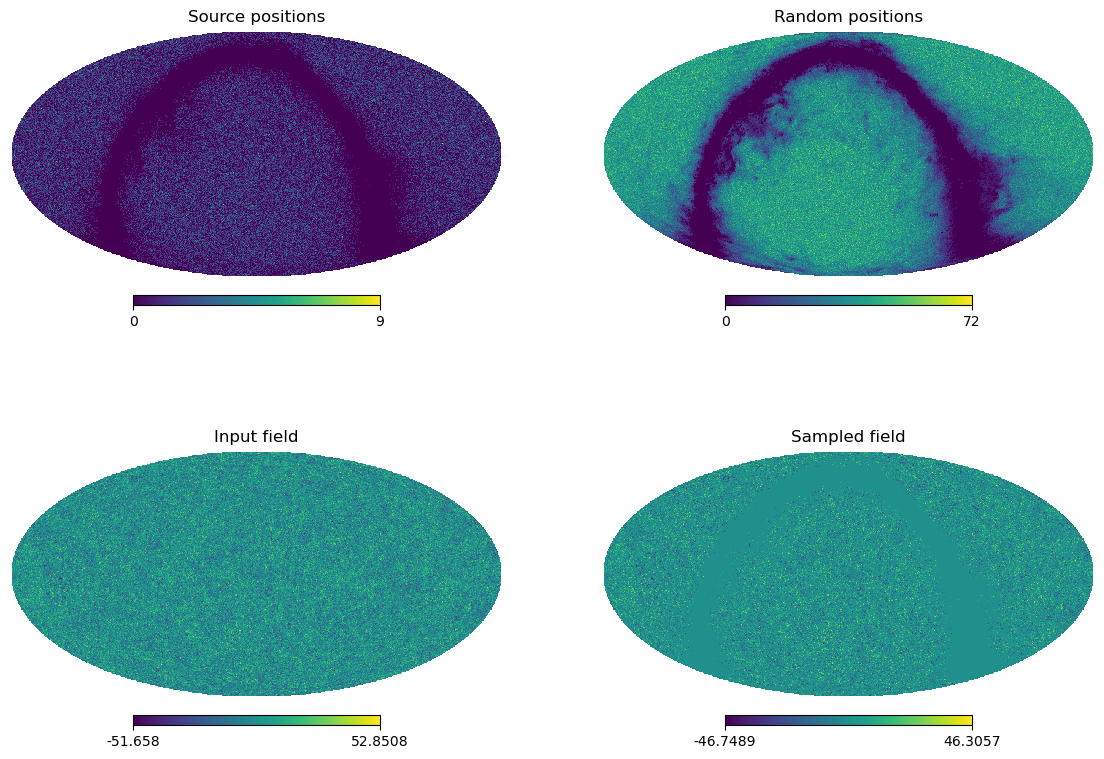

In [3]:
nside = 256
npix = hp.nside2npix(nside)
lmax = 300
lmax_nside = 3*nside-1
ls = np.arange(lmax_nside+1)
pixwin = hp.pixwin(nside)
cl_true = 1/(ls+10)

# Simulator
def gen_sim(spin=0):
    if spin == 0:
        mp = hp.synfast(cl_true, nside)
    else:
        almE = hp.synalm(cl_true)
        almB = almE*0
        mp = np.array(hp.alm2map_spin([almE, almB], nside,
                                      spin, lmax_nside))
    return mp

# Catalog positions
pos_data = np.array([cat['ra'], cat['dec']])

# Catalog weights
w_data = np.ones(nsrc)

# Generate continuous map
mp = gen_sim()
# Calculate pixel indices for each souce
ipix = hp.ang2pix(nside, pos_data[0], pos_data[1], lonlat=True)
# Assign field values from sky positions
fval = mp[ipix]

# Plot the source distribution and the field values, so we get an
# idea of what the data looks like
nc_data = np.bincount(ipix, minlength=npix)
nc_ran = np.bincount(hp.ang2pix(nside, pos_ran[0], pos_ran[1], lonlat=True),
                     minlength=npix)
mp_cat = np.bincount(ipix, minlength=npix, weights=fval)
mp_cat[nc_data > 0] = mp_cat[nc_data > 0] / nc_data[nc_data > 0]

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
plt.axes(axes[0][0])
hp.mollview(nc_data, title='Source positions', hold=True)
plt.axes(axes[0][1])
hp.mollview(nc_ran, title='Random positions', hold=True)
plt.axes(axes[1][0])
hp.mollview(mp, title='Input field', hold=True)
plt.axes(axes[1][1])
hp.mollview(mp_cat, title='Sampled field', hold=True)

OK, now that we have all the data, this is how you create a `NmtFieldCatalog` object:

In [4]:
fld = nmt.NmtFieldCatalog(pos_data, w_data, fval, lmax=lmax, lmax_mask=4*lmax, lonlat=True)

You can then use this field to compute power spectra the same way you would for normal NaMaster fields.

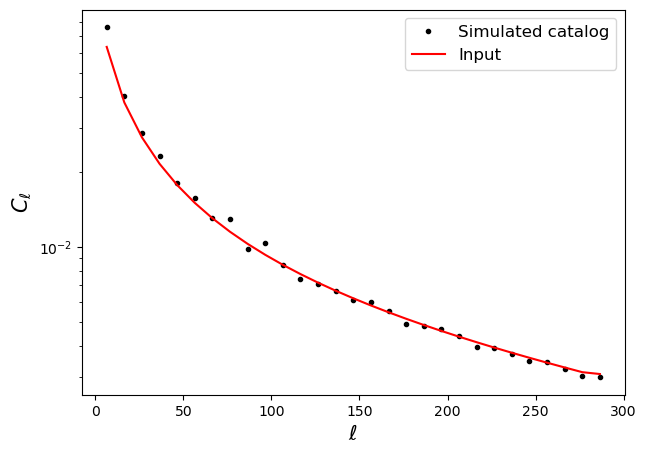

In [5]:
b = nmt.NmtBin.from_lmax_linear(lmax, nlb=10)
w = nmt.NmtWorkspace()
w.compute_coupling_matrix(fld, fld, b)
pcl = nmt.compute_coupled_cell(fld, fld)
cl = w.decouple_cell(pcl)

leff = b.get_effective_ells()
plt.figure(figsize=(7, 5))
plt.plot(leff, cl[0], 'k.', label='Simulated catalog')
# Note that we need to correct the input power spectrum for the pixel window
# function we used to generate the simulation.
plt.plot(leff, w.decouple_cell(w.couple_cell([cl_true*pixwin**2]))[0], 'r-', label='Input')
plt.yscale('log')
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.legend(fontsize=12)